Daily crime matrix shape: (633, 27)


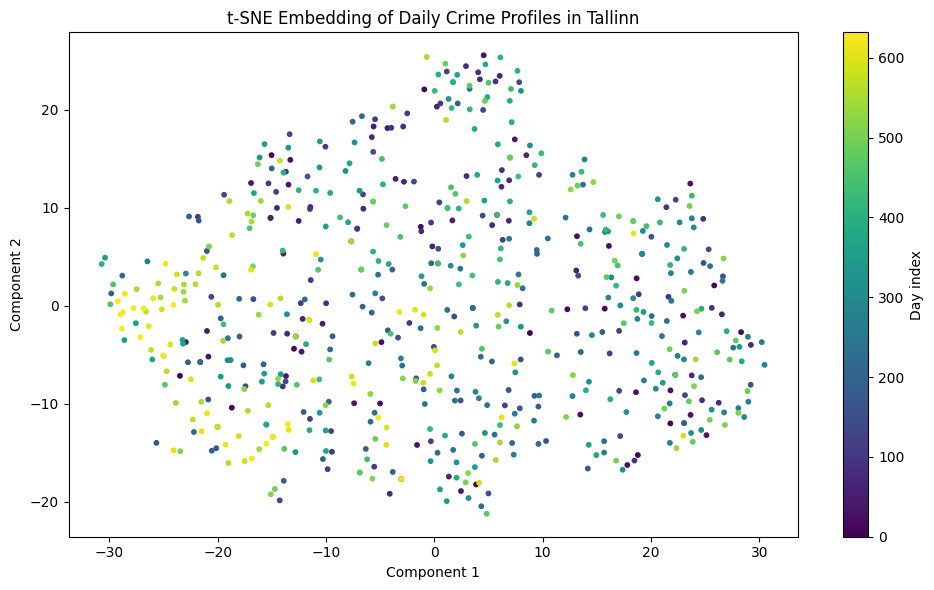

In [2]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────
# Step 1: Load and parse data
# ─────────────────────────────────────────────────────

# Load the dataset
dat = pd.read_csv('/home/maria/CrimeStats/data/avalik_1.csv', sep='\t')

# Filter to only Tallinn
tallinn = dat[dat['ValdLinnNimetus'] == 'Tallinn'].copy()

# Parse date
tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')

# Fill missing times with midnight and convert to timedelta
tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
tallinn['ToimKell'] = pd.to_timedelta(tallinn['ToimKell'] + ':00')

# Combine date and time into a full datetime
tallinn['ToimDatetime'] = tallinn['ToimKpv'] + tallinn['ToimKell']
tallinn = tallinn.dropna(subset=['ToimDatetime'])

# Set datetime index
tallinn.set_index('ToimDatetime', inplace=True)

# ─────────────────────────────────────────────────────
# Step 2: Clean crime type and count per day
# ─────────────────────────────────────────────────────

# Keep only the first part of crime type (before comma)
tallinn['CrimeType'] = tallinn['SyndmusLiik'].astype(str).apply(lambda x: x.split(',')[0])

# Count daily occurrences of each crime type
daily_matrix = tallinn.groupby([tallinn.index.date, 'CrimeType']).size().unstack(fill_value=0)
daily_matrix.index = pd.to_datetime(daily_matrix.index)
daily_matrix = daily_matrix.sort_index()

print("Daily crime matrix shape:", daily_matrix.shape)

# ─────────────────────────────────────────────────────
# Step 3: Embed using t-SNE
# ─────────────────────────────────────────────────────

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding = tsne.fit_transform(daily_matrix.values)

# ─────────────────────────────────────────────────────
# Step 4: Plot the result
# ─────────────────────────────────────────────────────

plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1],
            c=np.arange(len(embedding)), cmap='viridis', s=10)
plt.colorbar(label='Day index')
plt.title("t-SNE Embedding of Daily Crime Profiles in Tallinn")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


In [4]:
from lib import train_cebra_time_learnable_siren

encoder = train_cebra_time_learnable_siren(
    data=daily_matrix.values,
    input_dim=27,
    hidden_dim=32,
    output_dim=3,
    num_layers=3,
    num_frequencies=3,
    omega_init_range=(1.0, 60.0),
    epochs=1000,
    batch_size=64,
    learning_rate=1e-3,
    model_path="crime_siren_multi.pt"
)

[LearnableFreqSIREN] Epoch 0, Loss: 2.8344
[LearnableFreqSIREN] Epoch 100, Loss: 3.3234
[LearnableFreqSIREN] Epoch 200, Loss: 3.1452
[LearnableFreqSIREN] Epoch 300, Loss: 1.0626
[LearnableFreqSIREN] Epoch 400, Loss: 0.7981
[LearnableFreqSIREN] Epoch 500, Loss: 0.7531
[LearnableFreqSIREN] Epoch 600, Loss: 0.7432
[LearnableFreqSIREN] Epoch 700, Loss: 0.7441
[LearnableFreqSIREN] Epoch 800, Loss: 0.6663
[LearnableFreqSIREN] Epoch 900, Loss: 0.6671
Learnable frequency SIREN model saved to crime_siren_multi.pt


Duplicate embeddings at indices: [3, 5, 6, 12, 15, 17, 22, 42, 45, 52, 56, 93, 94, 134, 149, 150, 207, 221, 294, 300, 324, 340, 341, 350, 358, 367, 368, 371, 418, 452, 453, 457, 563, 585, 631]
torch.Size([633, 3])
Saved rotating embedding animation to tallinn_crime_rotation.mp4


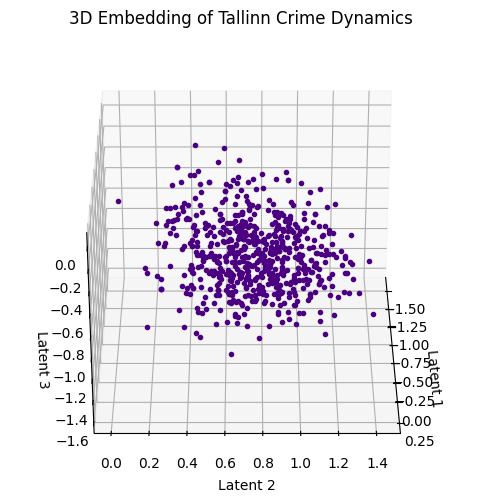

In [5]:
from lib import animate_embedding_3d_learnable_siren

animate_embedding_3d_learnable_siren(
    data=daily_matrix.values,
    encoder_path="crime_siren_multi.pt",
    input_dim=27,
    hidden_dim=32,
    output_dim=3,
    num_layers=3,
    num_frequencies=3,
    omega_init_range=(1.0, 60.0),
    title="3D Embedding of Tallinn Crime Dynamics",
    save_path="tallinn_crime_rotation.mp4"
)

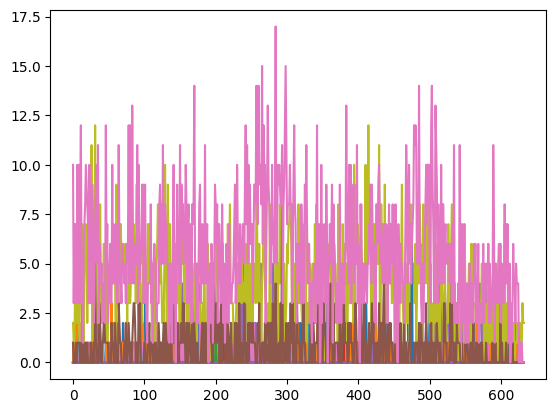

In [6]:
import matplotlib.pyplot as plt

plt.plot(daily_matrix.values)

In [3]:
print(daily_matrix.values.shape)

(633, 27)
